<a href="https://colab.research.google.com/github/alwanfa/neural-network-exploration/blob/main/ComplexAddingMachine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [178]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import copy
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [245]:
def createDataset(n) :
  x = torch.randint(-10,10, size = (n,2)).float()
  y = torch.sum(x, axis = 1, keepdim = True)
  X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2)
  X_devset, X_test, y_devset, y_test = train_test_split(X_test,y_test, test_size=0.5)
  train_dataset = TensorDataset(X_train,y_train)
  dev_dataset = TensorDataset(X_devset,y_devset)
  test_dataset = TensorDataset(X_test,y_test)
  return train_dataset, dev_dataset, test_dataset

In [247]:
train_dataset, dev_dataset, test_dataset = createDataset(10000)
batchsize    = 32
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])
dev_loader  = DataLoader(dev_dataset,batch_size=dev_dataset.tensors[0].shape[0])

In [237]:
print(f"train shape : {train_dataset.tensors[0].shape}")
print(f"devset shape : {dev_dataset.tensors[0].shape}")
print(f"test shape : {test_dataset.tensors[0].shape}")

train shape : torch.Size([8000, 2])
devset shape : torch.Size([1000, 2])
test shape : torch.Size([1000, 2])


In [238]:
for i, j in zip(test_dataset.tensors[0][:10], test_dataset.tensors[1][:10]) :
  print(f"{i[0]} + {i[1]} = {j}")

0 + 1 = tensor([1])
-1 + 7 = tensor([6])
-3 + 6 = tensor([3])
8 + 7 = tensor([15])
-2 + -3 = tensor([-5])
-7 + -5 = tensor([-12])
5 + 3 = tensor([8])
-8 + -3 = tensor([-11])
-9 + -6 = tensor([-15])
-2 + -2 = tensor([-4])


In [239]:
# create a class for the model
def createAddingMachineNet():

  class AddingMachineNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(2,8)

      # ### hidden layer
      self.fc1 = nn.Linear(8,8)
      self.fc2 = nn.Linear(8,8)
      ### output layer
      self.output = nn.Linear(8,1)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)

  # create the model instance
  net = AddingMachineNet()

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [225]:
# test the model with one batch
net,lossfun,optimizer = createAddingMachineNet()

X,y = next(iter(train_loader))
yHat = net(X)

# values are log-probability of each number (0-9)
# print(torch.exp(yHat))

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
Loss:
tensor(471.7541, grad_fn=<MseLossBackward0>)


In [260]:
def function2trainTheModel():

  # number of epochs
  numepochs = 50

  theBestModel = {'Accuracy':0, 'net':None}

  # create a new model
  net,lossfun,optimizer = createAddingMachineNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  devsetAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y,)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    predict = net(train_dataset.tensors[0])


    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append(100*torch.mean((np.abs(predict.detach()-train_dataset.tensors[1])<1).float() ))

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(dev_loader)) # extract X,y from devset dataloader
    yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    devsetAcc.append( 100*torch.mean((np.abs(yHat.detach()-y)<1).float()) )

    if devsetAcc[-1]>theBestModel['Accuracy']:

      # new best accuracy
      theBestModel['Accuracy'] = devAcc[-1].item()

      # model's internal state
      theBestModel['net'] = copy.deepcopy( net.state_dict() )

  # end epochs

  # function output
  return trainAcc,devsetAcc,losses, theBestModel


In [259]:
train_dataset.tensors[1]

tensor([[ -3.],
        [-18.],
        [-11.],
        ...,
        [  0.],
        [ -9.],
        [ 10.]])

In [261]:
trainAcc,devAcc,losses,net = function2trainTheModel()


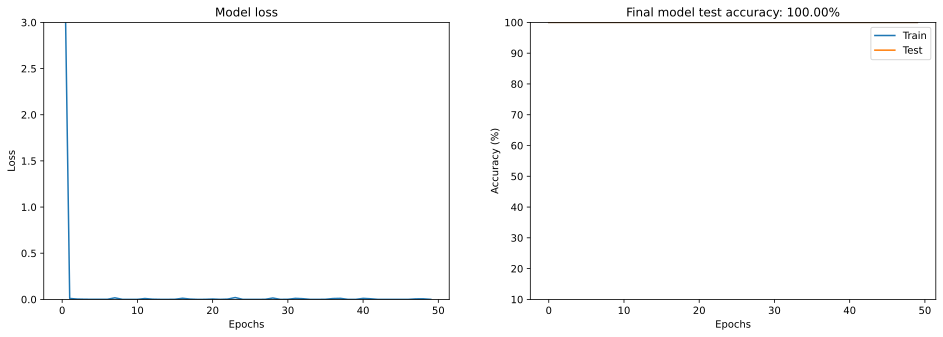

In [262]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(devAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {devAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [263]:
for i in range(10) :
  trainAcc,devAcc,losses,net = function2trainTheModel()
  X,y = test_dataset.tensors # extract X,y from devset dataloader
  bestnet = createAddingMachineNet()[0]
  bestnet.load_state_dict(net['net'])
  yHat = bestnet(X)
  testAcc = 100*torch.mean((np.abs(yHat.detach()-y)<1).float())
  print(f"model instance {i}, train accuracy : {max(trainAcc)}, dev accuracy : {net['Accuracy']}, test Accuracy : {testAcc}")

  # compare the following really long line of code to the training accuracy lines


model instance 0, train accuracy : 100.0, dev accuracy : 100.0, test Accuracy : 100.0
model instance 1, train accuracy : 100.0, dev accuracy : 100.0, test Accuracy : 100.0
model instance 2, train accuracy : 100.0, dev accuracy : 100.0, test Accuracy : 100.0
model instance 3, train accuracy : 100.0, dev accuracy : 100.0, test Accuracy : 100.0
model instance 4, train accuracy : 100.0, dev accuracy : 100.0, test Accuracy : 100.0
model instance 5, train accuracy : 100.0, dev accuracy : 100.0, test Accuracy : 100.0
model instance 6, train accuracy : 100.0, dev accuracy : 100.0, test Accuracy : 100.0
model instance 7, train accuracy : 100.0, dev accuracy : 100.0, test Accuracy : 100.0
model instance 8, train accuracy : 100.0, dev accuracy : 100.0, test Accuracy : 100.0
model instance 9, train accuracy : 100.0, dev accuracy : 100.0, test Accuracy : 100.0


In [272]:
X,y = test_dataset.tensors
testpredict = bestnet(X)

In [273]:
testpredict

tensor([[ 5.1427e+00],
        [ 3.9589e+00],
        [ 1.0947e+00],
        [-9.7819e-01],
        [-2.9888e+00],
        [-3.6566e+00],
        [-7.1266e+00],
        [ 8.0649e+00],
        [ 1.1017e+01],
        [-2.3989e-01],
        [-3.2363e+00],
        [ 3.0381e+00],
        [-1.7996e+01],
        [ 1.0023e+01],
        [-1.9930e+01],
        [-4.1388e+00],
        [-6.0089e+00],
        [-1.0060e+01],
        [ 6.1363e+00],
        [ 1.2945e+01],
        [-2.0436e+00],
        [ 7.1300e+00],
        [-7.1011e+00],
        [-1.4008e+01],
        [-4.1929e+00],
        [-1.5022e+01],
        [-1.1074e+01],
        [-1.5982e+01],
        [-5.9266e+00],
        [-6.0044e+00],
        [-8.9382e+00],
        [ 4.1197e+00],
        [ 5.1427e+00],
        [-5.9266e+00],
        [ 7.9793e+00],
        [ 1.0987e+01],
        [-1.2064e+00],
        [-1.5022e+01],
        [-4.0846e+00],
        [-1.6989e+01],
        [-7.0725e+00],
        [ 7.0609e+00],
        [-1.5022e+01],
        [ 7

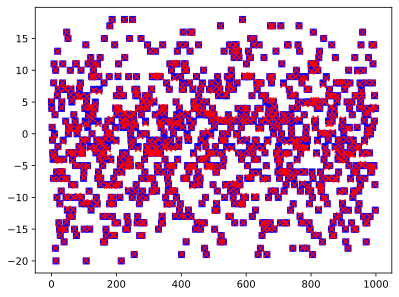

In [274]:
plt.scatter(np.arange(1000), y,  marker = 's', c = 'b')
plt.scatter(np.arange(1000), testpredict.detach(),  marker = 'x', c = 'r')